### Workflow summary:

- Work on .py files to produce reports (instead of .ipynb files) to make git integration easier.
- Declare the parameters at the top, tagging the cell as "parameters".
- Before executing the notebook, validate your .py files using pyflakes.
- Execute your notebook using papermill.

First, I import the necessary modules, load the original dataset containing observations for 12 most recent completed weeks and set the plotting parameters.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os 
import matplotlib.pyplot as plt
os.chdir("/Users/aida.aman/Desktop/Bolt")
main = pd.read_csv("tickets.csv")
plt.rcParams["figure.figsize"] = (70,50)
plt.style.use('seaborn-whitegrid')

Then, I generate the hourly time-series of incoming tickets and create separate indices for hour-of-the-day and day-of-week.

In [2]:
main = main.dropna(how='all', subset=['first_response_time'])
main = main.rename(columns={'ticket_created_at':'date'})
main['date'] = pd.to_datetime(main['date'])
main['is_incoming'] = main['is_incoming'].replace('t', 1)
main['is_incoming'] = main['is_incoming'].replace('f', 0)
main = main.drop_duplicates(subset=['id'])
main = main.drop(columns=['id', 'ticket_first_responded_at', 'ticket_last_solved_at'])
main = main.set_index(pd.DatetimeIndex(main['date']))
main_byhour = main['is_incoming'].resample('H').sum()
main_byhour = main_byhour.to_frame()

In [3]:
main_byhour = main_byhour.reset_index()
main_byhour['hour'] = main_byhour['date'].dt.hour
main_byhour['dow'] = main_byhour['date'].dt.day_name()
main_byhour = main_byhour.rename(columns={'is_incoming':'vol'})
main_byhour = main_byhour.drop(columns=['date'])

Now, I generate a pivot table grouping incoming tickets by hour and day of week and visualize the grouped values for the entire time period. 

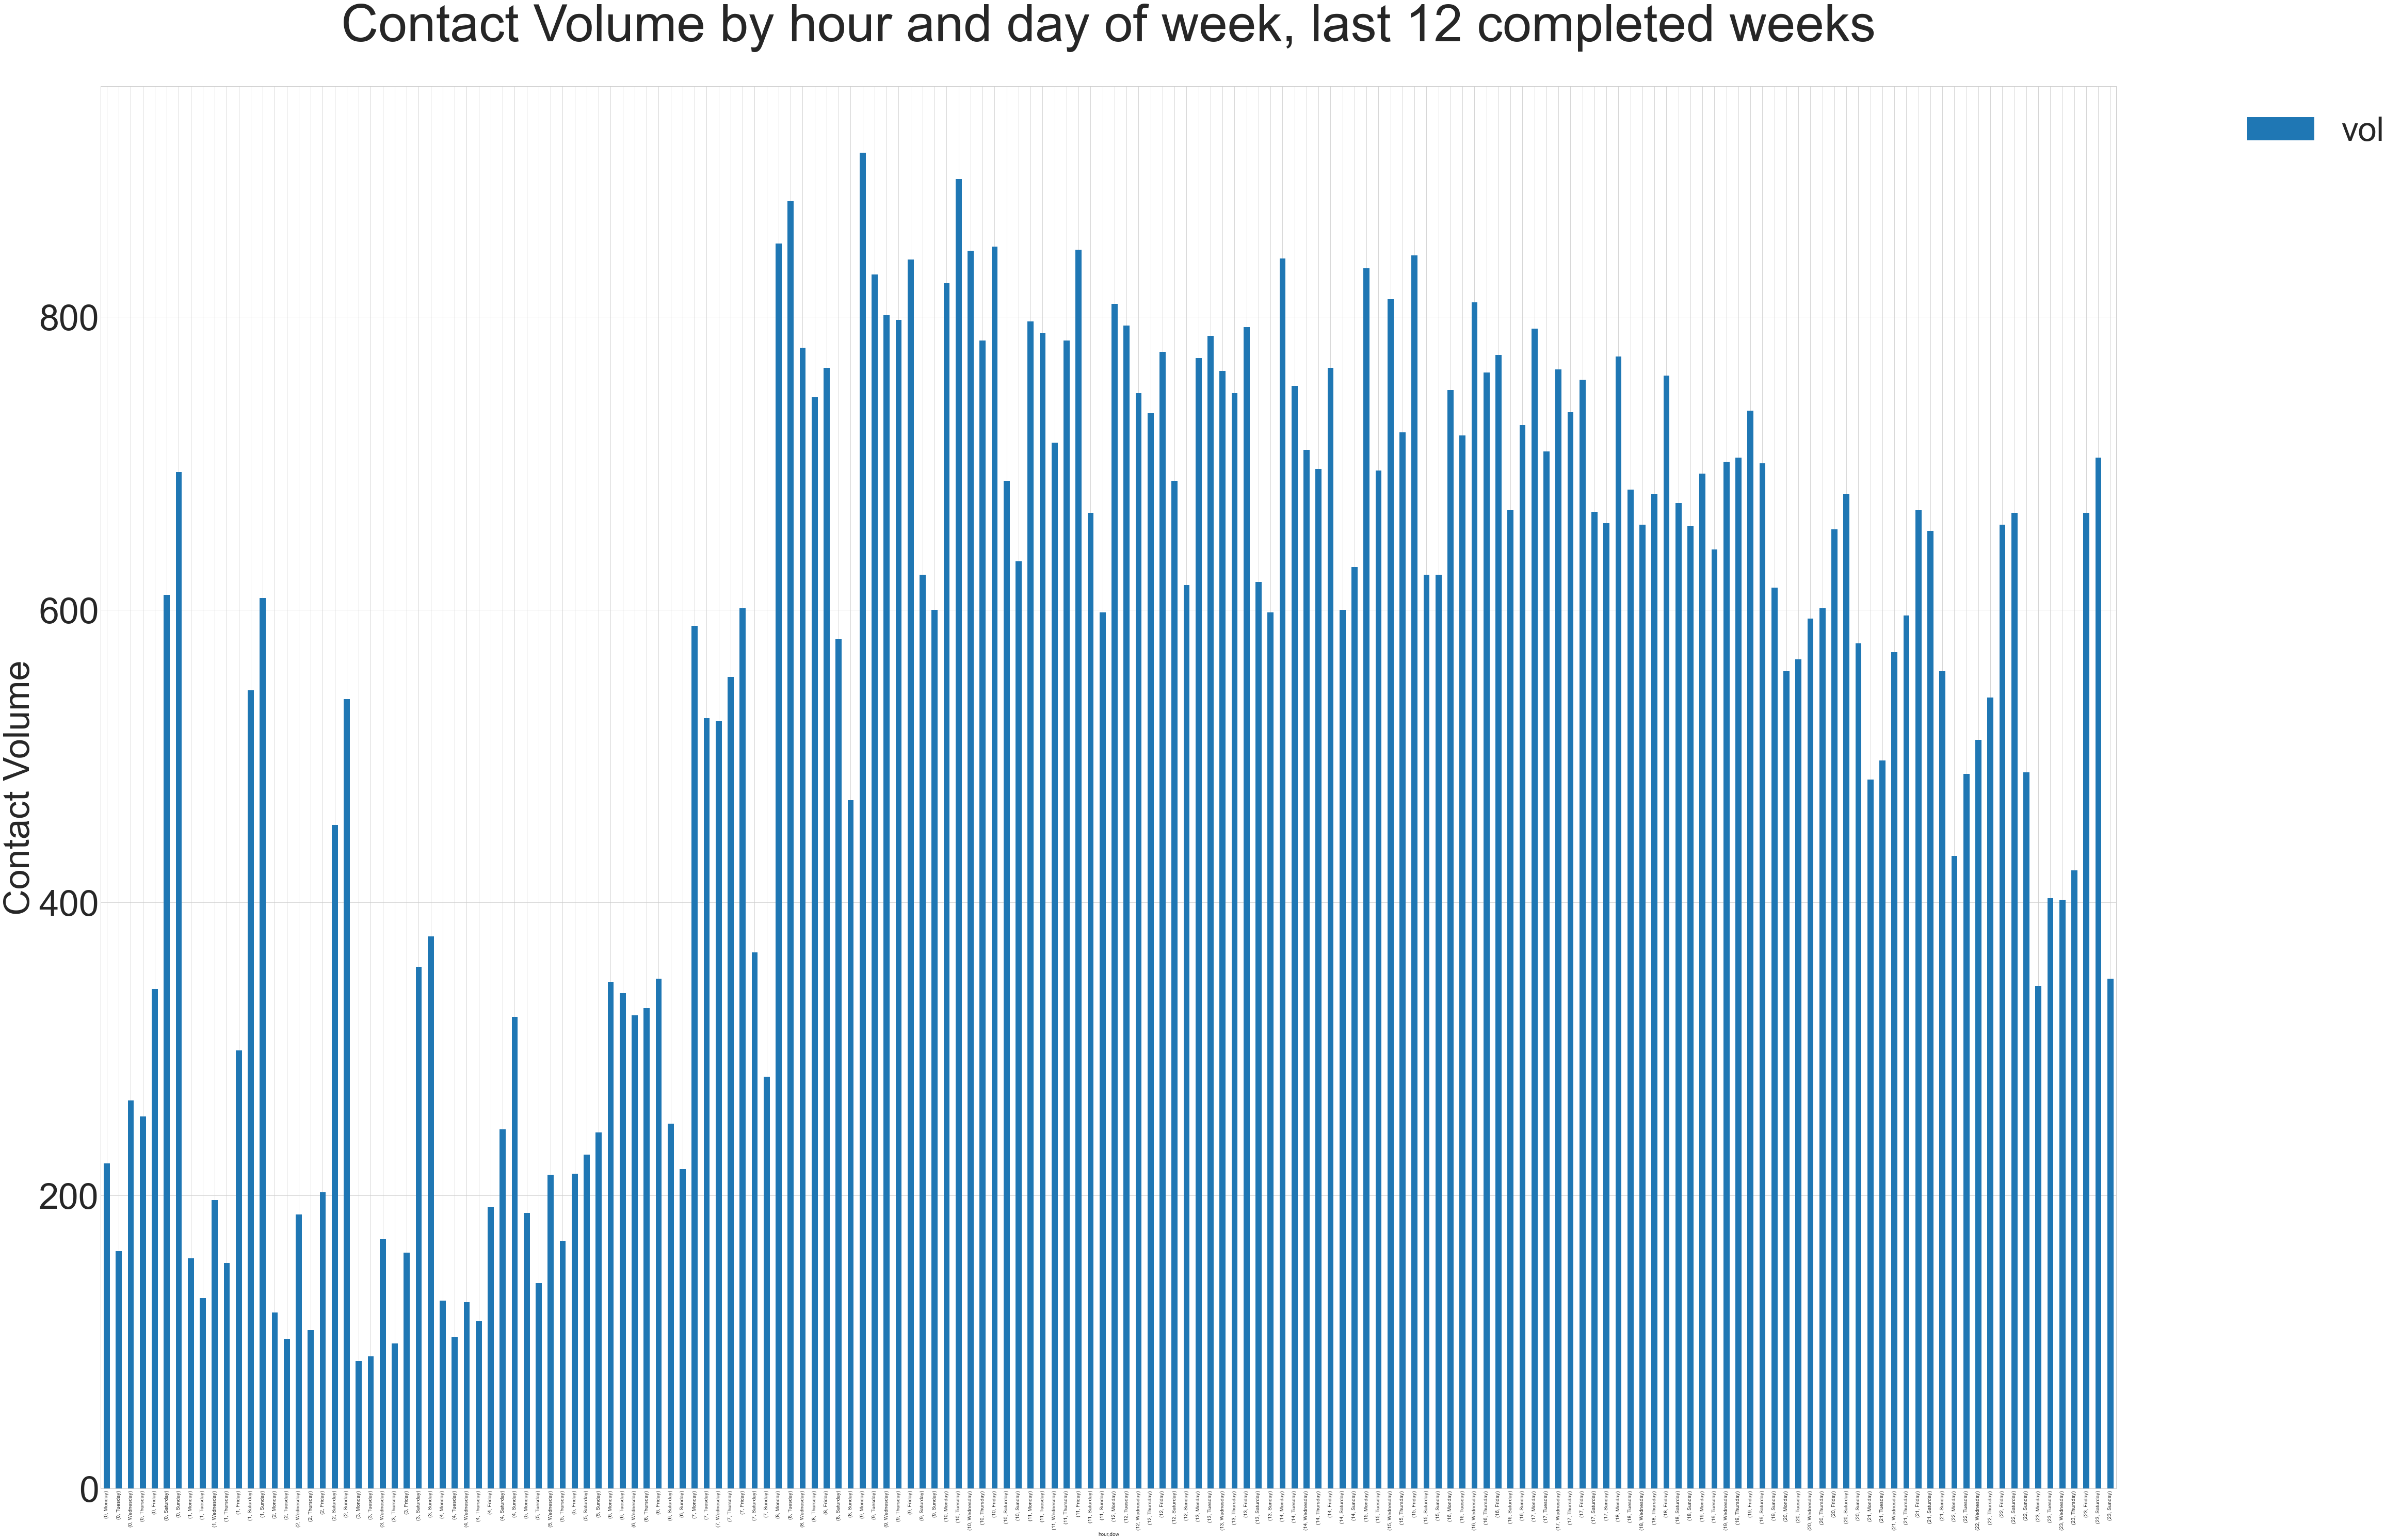

In [38]:
patterns = pd.pivot_table(main_byhour, values=['vol'], index=['hour', 'dow'],
                    aggfunc={'vol': np.sum})
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
patterns = patterns.reindex(cats, level=1)
patterns.plot(kind = 'bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5,prop={'size':65})
plt.title('Contact Volume by hour and day of week, last 12 completed weeks', fontsize=100, y=1.03)
plt.ylabel('Contact Volume', fontsize=70)
label_size = 70
degrees = 0
plt.yticks(fontsize = label_size)
plt.show()

Here, I group the tickets by hour and day of week using the latter as columns and visualize the results.

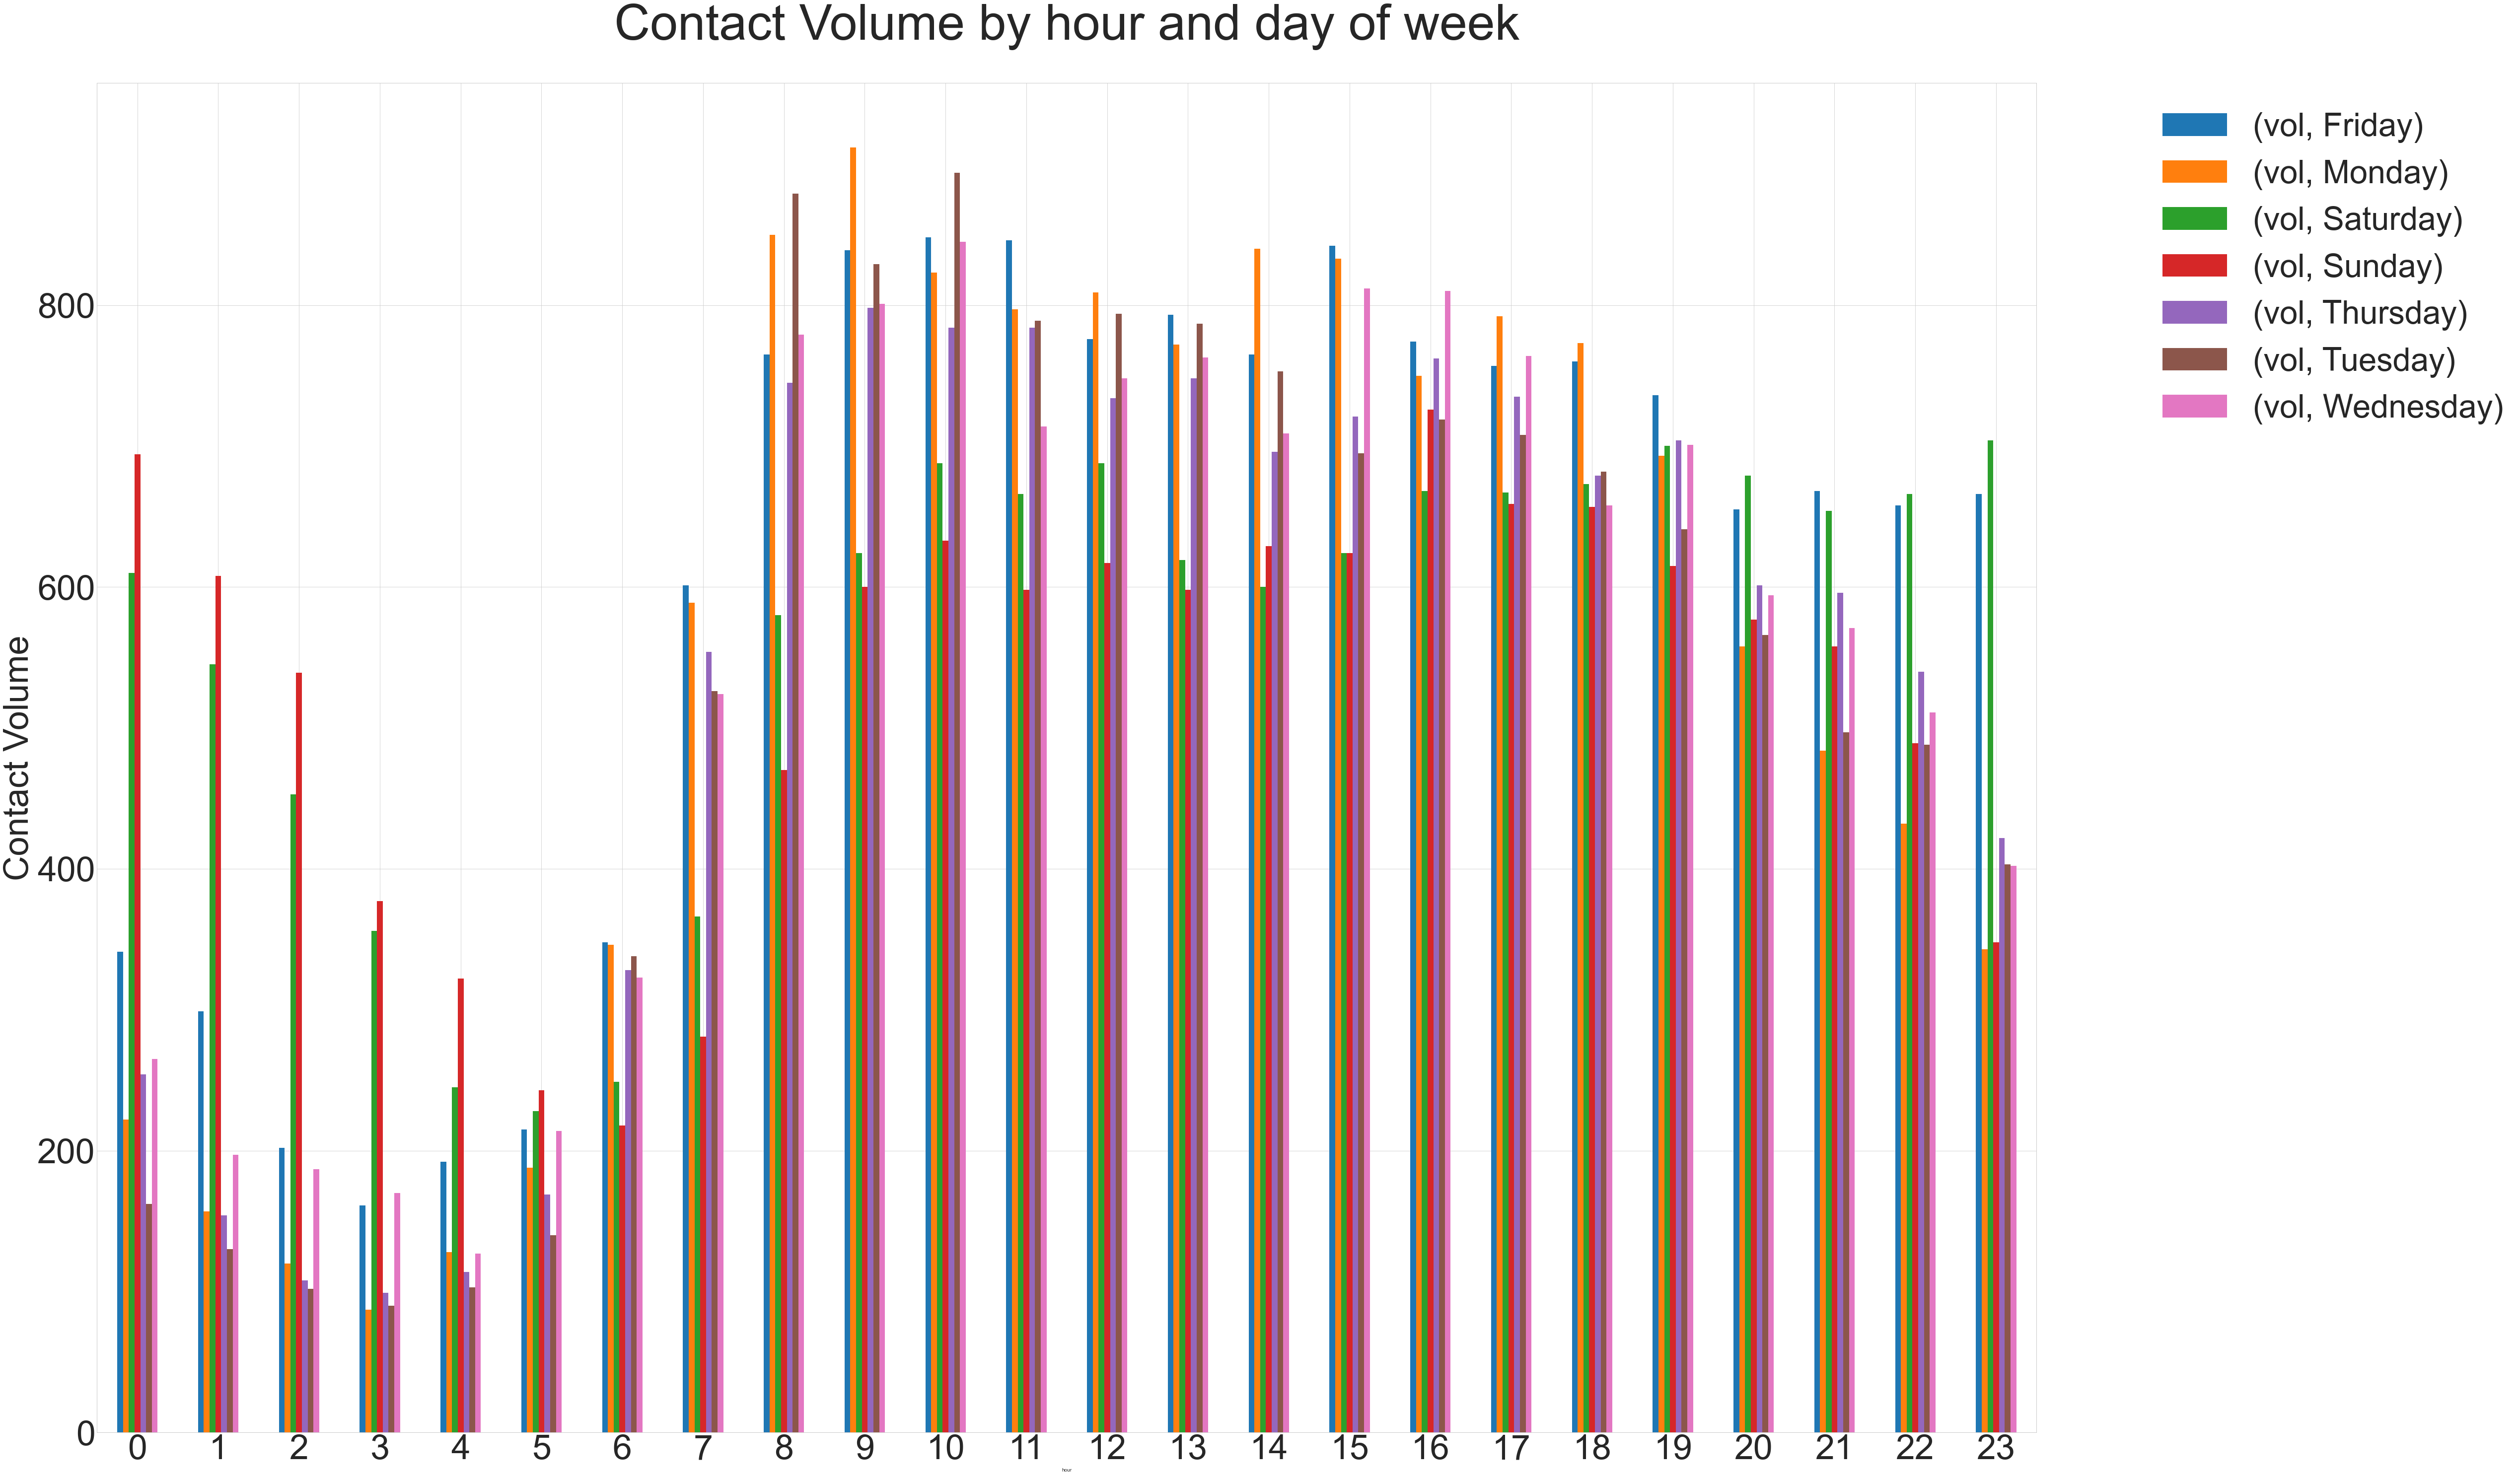

In [36]:
patterns2 = pd.pivot_table(main_byhour,index=['hour'],columns=['dow'],values=['vol'],aggfunc=np.sum)
patterns2.plot(kind='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5,prop={'size':65})
plt.title('Contact Volume by hour and day of week', fontsize=100, y=1.03)
plt.ylabel('Contact Volume', fontsize=70)
label_size = 70
degrees = 0
plt.xticks(fontsize = label_size, rotation=degrees)
plt.yticks(fontsize = label_size)
plt.show()

Here, I group the tickets by hour and day of week using the latter as rows.

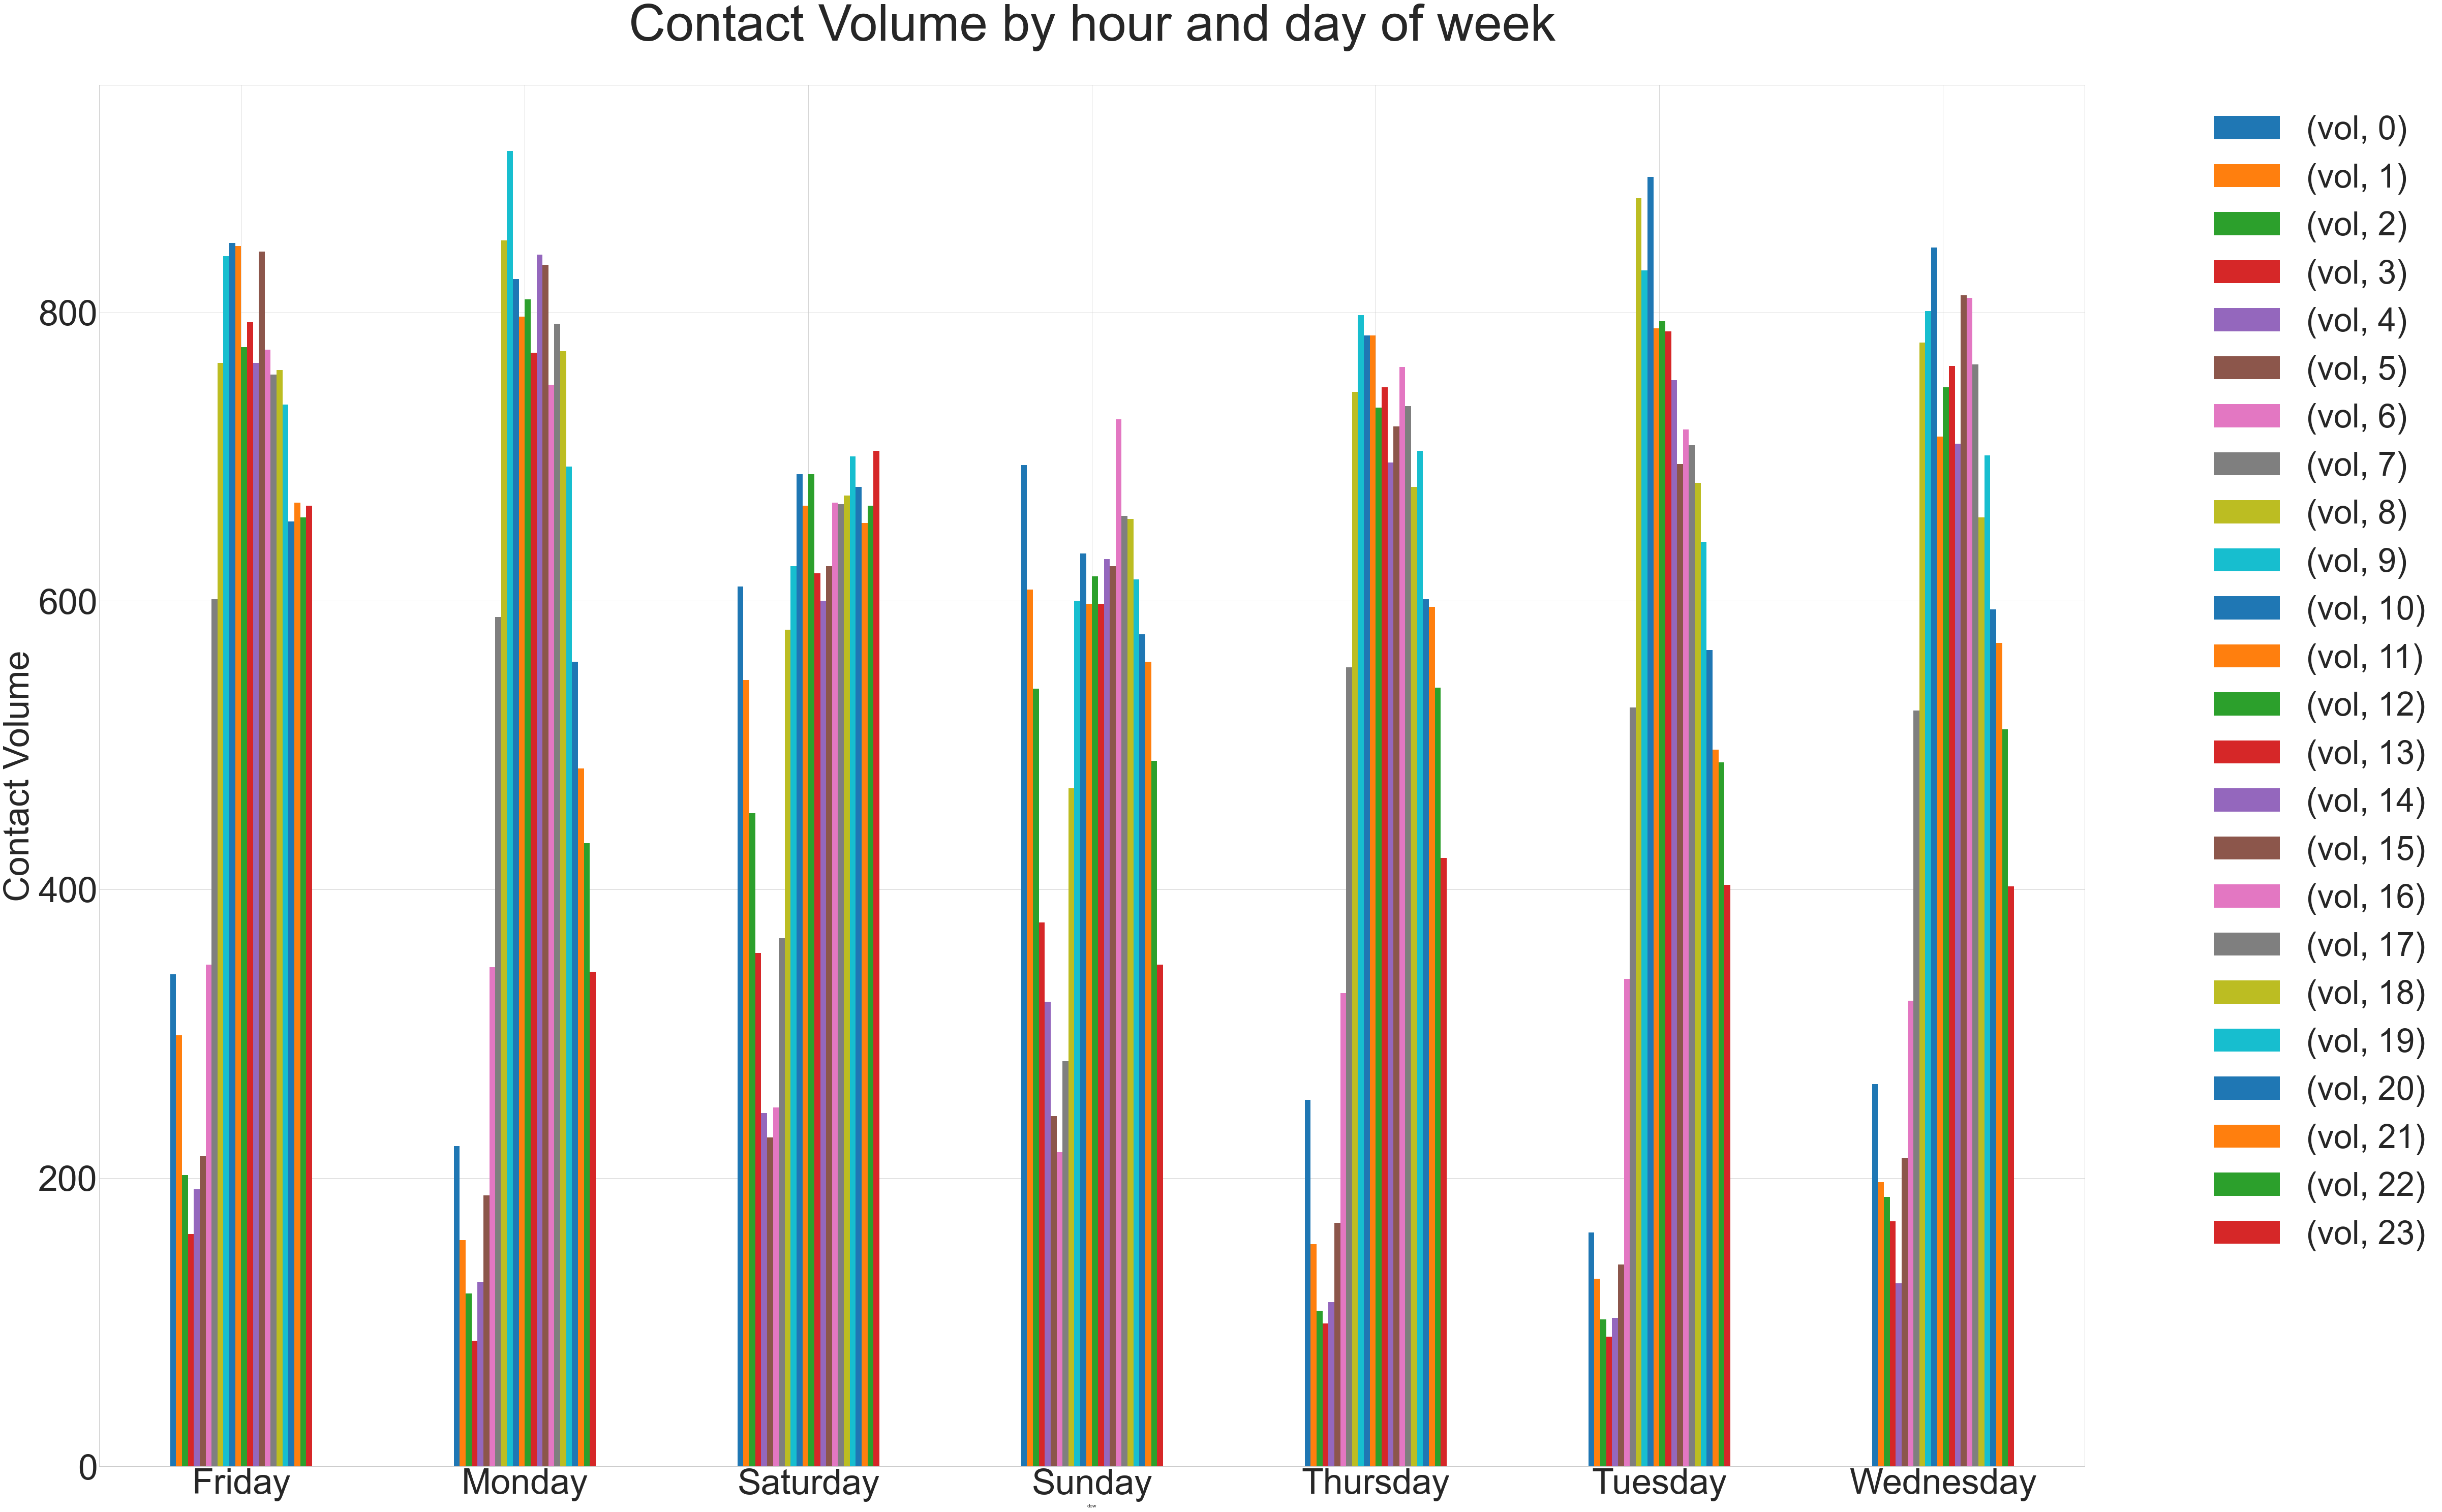

In [35]:
patterns3 = pd.pivot_table(main_byhour,index=['dow'],columns=['hour'],values=['vol'],aggfunc=np.sum)
patterns3.plot(kind='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5,prop={'size':65})
plt.title('Contact Volume by hour and day of week', fontsize=100, y=1.03)
plt.ylabel('Contact Volume', fontsize=70)
label_size = 70
degrees = 0
plt.xticks(fontsize = label_size, rotation=degrees)
plt.yticks(fontsize = label_size)
plt.show()

Now, I can also generate the intraweek distribution.

In [7]:
intraweek = pd.pivot_table(main_byhour, values=['vol'], index=['dow'],
                    aggfunc={'vol': np.sum})
intraweek = intraweek.reindex(cats)
intraweek['pct_of_total']=intraweek['vol']/np.sum(intraweek['vol'])

I can also generate the distribution for early and late shifts. The incoming complaints that are to be addressed by agents scheduled for an early shift are the ones that arrive before 16:00, while the ones that are to be addressed by the late shift agents are the ones arriving after 16:00.

In [18]:
main_byhour["late"] = (main_byhour["hour"] >= 16)* 1
main_byhour["early"] = (main_byhour["hour"] < 16)* 1

In [19]:
main_byhour['shift'] = np.where(main_byhour['early'] == 1, 'early', 'late')

In [29]:
shifts = main_byhour[['shift', 'vol', 'dow']]
shift_patterns = pd.pivot_table(shifts,index=['shift'],columns=['dow'],values=['vol'],aggfunc=np.sum)

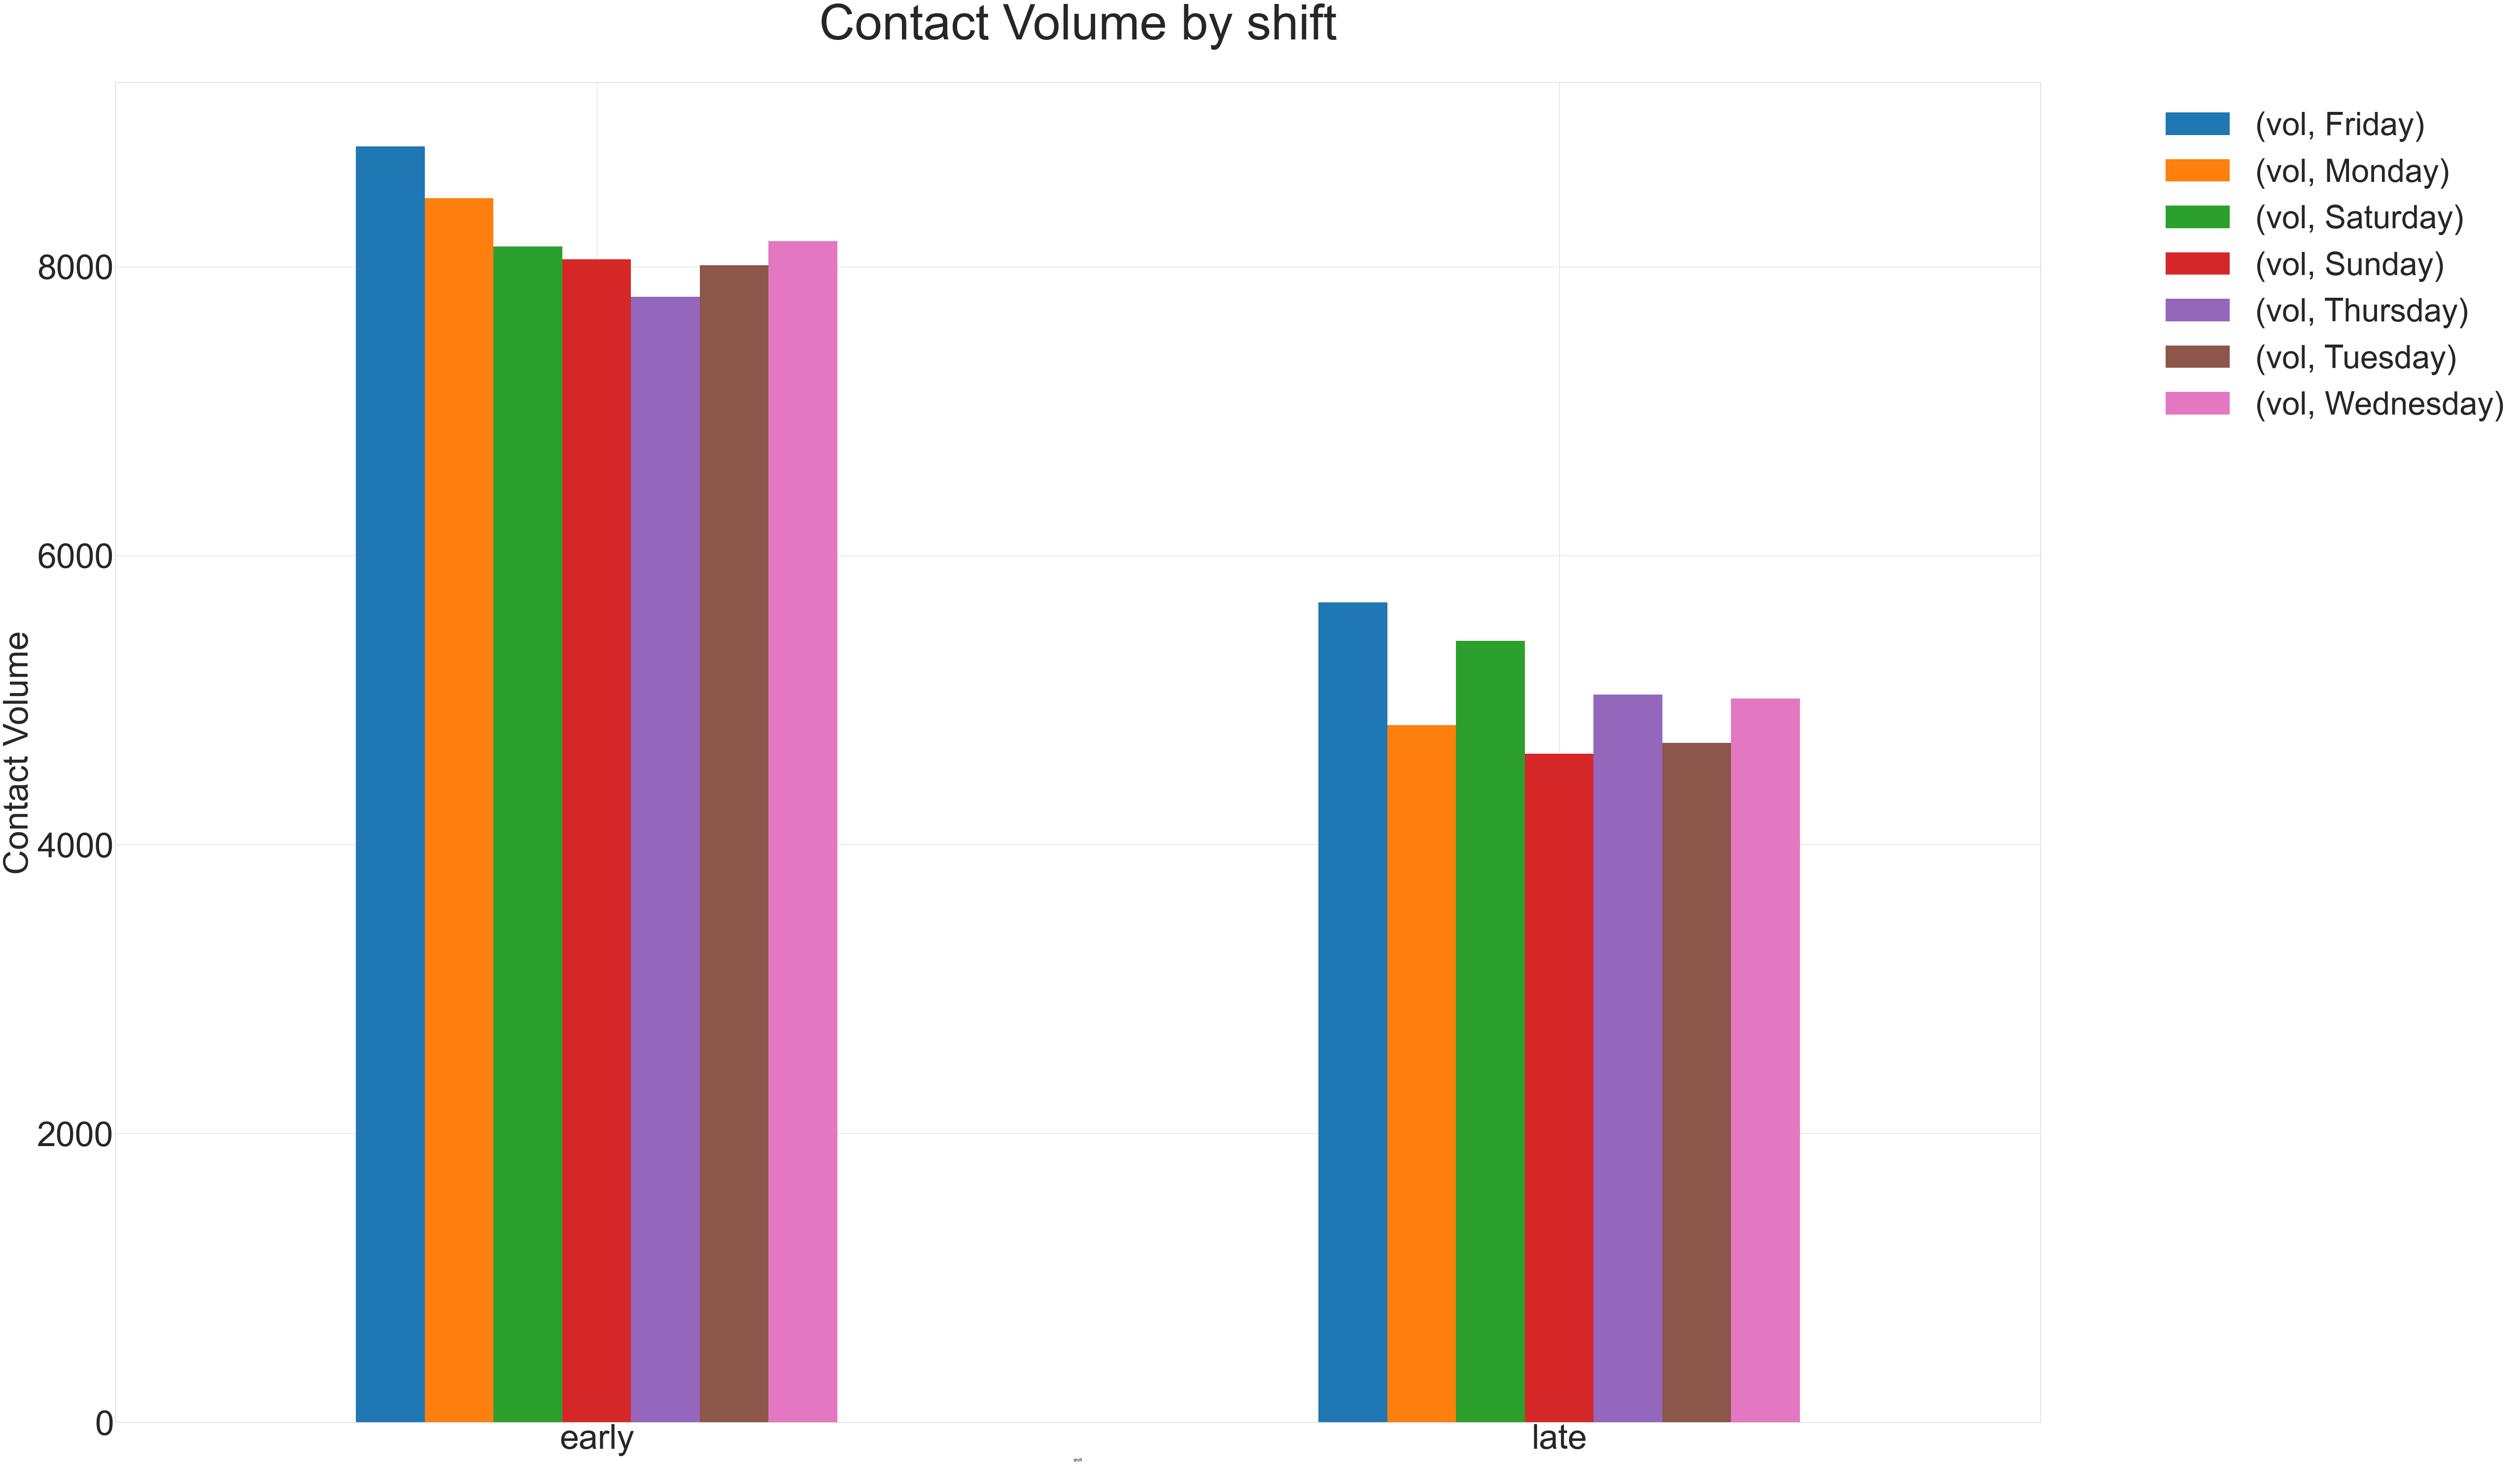

In [34]:
shift_patterns.plot(kind='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5,prop={'size':65})
plt.title('Contact Volume by shift', fontsize=100, y=1.03)
plt.ylabel('Contact Volume', fontsize=70)
label_size = 70
degrees = 0
plt.xticks(fontsize = label_size, rotation=degrees)
plt.yticks(fontsize = label_size)
plt.show()

The final step is calculating the FTE equivalent of the agent need forecast and exporting out the data to be handed to TL-s, who are the ones designing the shifts.